# making_augmentation set

*매 시행은 label 개수가 2000개 이하인 것들에 대해서만 수행한다.*

1. 1번째 시행. mask_replacement (문장 길이의 10% 적용, entity 미보존)
2. 2번째 시행. mask_random_insertion (문장 길이의 10% 적용, entity 미보존)
3. 3번째 시행. 반말 -> 존댓말 변환 (entity 보존)
4. 4번째 시행. aeda (문장 길이의 10%, entity 미보존)

In [968]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import random
import string
from konlpy.tag import Mecab

from py_hanspell.hanspell import spell_checker
from jamo import h2j, j2hcj, j2h, jamo_to_hcj
import hgtk

import time
from collections import defaultdict
mecab = Mecab()
import torch
import transformers
import numpy as np
from changer import Changer

In [1931]:
torch.cuda.empty_cache()

In [1727]:
# train set
train_df = pd.read_csv('train/train.csv')
print(len(train_df))
train_df['aug_method'] = 'original'

29185


In [944]:
# seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(False)

In [945]:
# load tokenizer, PLM
roberta = transformers.AutoModelForMaskedLM.from_pretrained('klue/roberta-large')
tokenizer = transformers.AutoTokenizer.from_pretrained('klue/roberta-large')

In [946]:
# entity index 표시용 마커
entity_marker = ['[S1]', '[S2]', '[O1]', '[O2]']
sub_start_marker, sub_end_marker, obj_start_marker, obj_end_marker = [x for x in entity_marker]

add_token_num = tokenizer.add_special_tokens({"additional_special_tokens":entity_marker})
print(add_token_num)
roberta.resize_token_embeddings(len(tokenizer))
print(roberta.get_input_embeddings())

4
Embedding(32004, 1024)


In [1010]:
# unmasker model
unmasker = transformers.pipeline("fill-mask", model=roberta, tokenizer=tokenizer, device=0)

In [1731]:
# General utils
def label_filtering(df, n):
    """label이 n개 이상인 것들 제외하고 augmentation 수행하기 위해, 해당 label들을 filtering
    Args:
        df (dataframe): dataframe
    Returns:
        filterd_df (dataframe): label filtering이 적용된 dataframe
    """
    label_dict = dict(df['label'].value_counts())
    # 개수가 n 개 미만인 label만 필터링
    delete_list = [k for k, v in label_dict.items() if int(v) > n]
    filter_df = df[df['label'].apply(lambda x: x not in delete_list) == True]
    return filter_df

def sentence_with_entity_marker(df):
    """증강 과정에서 엔티티가 변형되지 않도록 보호하기 위해 문장에 엔티티 위치를 직접 표시

    Args:
        df (dataframe): dataframe

    Returns:
        df (dataframe): 엔티티 위치가 표시된 문장이 있는 칼럼을 추가한 dataframe
    """
    # entity를 dictionary 형으로 변환하고, 각 key-value 쌍을 별도의 칼럼으로 분리합니다.
    df['subject_entity'] = df['subject_entity'].apply(lambda x: literal_eval(x))
    df['object_entity'] = df['object_entity'].apply(lambda x: literal_eval(x))

    df['sub_word'] = df['subject_entity'].apply(lambda x: x['word'])
    df['obj_word'] = df['object_entity'].apply(lambda x: x['word'])

    df['sub_start_idx'] = df['subject_entity'].apply(lambda x: x['start_idx'])
    df['sub_end_idx'] = df['subject_entity'].apply(lambda x: x['end_idx'])

    df['obj_start_idx'] = df['object_entity'].apply(lambda x: x['start_idx'])
    df['obj_end_idx'] = df['object_entity'].apply(lambda x: x['end_idx'])

    df['sub_type'] = df['subject_entity'].apply(lambda x: x['type'])
    df['obj_type'] = df['object_entity'].apply(lambda x: x['type'])

    # 엔티티의 문장 내 위치를 marker로 로 표시해줍니다.
    df['sentence_with_entity_marker'] = None
    df['sub_extracted'] = None
    df['obj_extracted'] = None 

    for i in df.index:
        sub_start_idx = df['sub_start_idx'].loc[i]
        sub_end_idx = df['sub_end_idx'].loc[i]
        
        obj_start_idx = df['obj_start_idx'].loc[i]
        obj_end_idx = df['obj_end_idx'].loc[i]
        
        df['sub_extracted'].loc[i] = df['sentence'].loc[i][sub_start_idx:sub_end_idx+1]
        df['obj_extracted'].loc[i] = df['sentence'].loc[i][obj_start_idx:obj_end_idx+1]
        
        df['sentence_with_entity_marker'].loc[i] = list(df['sentence'].loc[i])
        
        # sub_entity, obj_entity 중 앞에 있는 엔티티에 먼저 마커를 붙여주면, 뒤에 있는 엔티티는 인덱스가 2만큼 밀려나는 것을 반영합니다.  
        
        if sub_start_idx < obj_start_idx:
        
            df['sentence_with_entity_marker'].loc[i].insert(sub_start_idx, ' ' + sub_start_marker + ' ')
            df['sentence_with_entity_marker'].loc[i].insert(sub_end_idx+2, ' ' + sub_end_marker + ' ')

            df['sentence_with_entity_marker'].loc[i].insert(obj_start_idx+2, ' ' + obj_start_marker + ' ')
            df['sentence_with_entity_marker'].loc[i].insert(obj_end_idx+4, ' ' + obj_end_marker + ' ')

        elif sub_start_idx > obj_start_idx:
            df['sentence_with_entity_marker'].loc[i].insert(obj_start_idx, ' ' + obj_start_marker + ' ')
            df['sentence_with_entity_marker'].loc[i].insert(obj_end_idx+2, ' ' + obj_end_marker + ' ')
            
            df['sentence_with_entity_marker'].loc[i].insert(sub_start_idx+2, ' ' + sub_start_marker + ' ')
            df['sentence_with_entity_marker'].loc[i].insert(sub_end_idx+4, ' ' + sub_end_marker + ' ')

        else:
            print('ERROR at ', i)
            print(df['sentence_with_entity_marker'].loc[i])
            break
            
        df['sentence_with_entity_marker'].loc[i] = ''.join(df['sentence_with_entity_marker'].loc[i]).strip()
        df['sentence_with_entity_marker'].loc[i] = re.sub('[ ]+', ' ', df['sentence_with_entity_marker'].loc[i])
        
    return df

# entity_re_indexing
def entity_re_indexing(df, aug_method_name):
    """변형 과정에서 바뀐 entity index를 entity 정보 dict에 업데이트해줍니다.

    Args:
        df (dataframe): dataframe
        aug_method_name (str): augmentation 방법의 이름 ex) 'honorific'

    Returns:
        df (dataframe): 변형 과정에서 바뀐 entity index를 반영한 dictionary 칼럼을 추가한 dataframe

    """
    df[aug_method_name + '_sub_start_idx'] = None
    df[aug_method_name + '_sub_end_idx'] = None

    df[aug_method_name + '_obj_start_idx'] = None
    df[aug_method_name + '_obj_end_idx'] = None

    df[aug_method_name + '_subject_entity_dict'] = None
    df[aug_method_name + '_object_entity_dict'] = None

    for i in range(len(df)):
        sub_word = re.findall(r'\w*\[S1\].+\[S2\]', df[aug_method_name].iloc[i])[0]
        obj_word = re.findall(r'\w*\[O1\].+\[O2\]', df[aug_method_name].iloc[i])[0]
        sub_word = re.sub(r'\w*\[S1\](.+)\[S2\]', r'\1', sub_word).strip()
        obj_word = re.sub(r'\w*\[O1\](.+)\[O2\]', r'\1', obj_word).strip()
        
        #TODO: ... [S2] [O1] ... 과 같이 두 엔티티가 연속으로 붙어 있을 때 뒤의 인덱스가 한칸 씩 밀리고 있다.
        if df[aug_method_name].iloc[i].find(sub_start_marker) < df[aug_method_name].iloc[i].find(obj_start_marker):

            df[aug_method_name + '_sub_start_idx'].iloc[i] = df[aug_method_name].iloc[i].find(sub_start_marker+ ' ') # len(entity_marker) == 4
            df[aug_method_name + '_sub_end_idx'].iloc[i] = df[aug_method_name + '_sub_start_idx'].iloc[i] + len(sub_word)
            # df[aug_method_name + '_sub_end_idx'].iloc[i] = df[aug_method_name].iloc[i].find(' ' + sub_end_marker)-5 # len('[S1] ' + ' ')

            df[aug_method_name + '_obj_start_idx'].iloc[i] = df[aug_method_name].iloc[i].find(obj_start_marker + ' ')-10
            df[aug_method_name + '_obj_end_idx'].iloc[i] = df[aug_method_name + '_obj_start_idx'].iloc[i] + len(obj_word)
            # df[aug_method_name + '_obj_end_idx'].iloc[i] = df[aug_method_name].iloc[i].find(' ' + obj_end_marker)-15

        elif df[aug_method_name].iloc[i].find(sub_start_marker) > df[aug_method_name].iloc[i].find(obj_start_marker):
            df[aug_method_name + '_obj_start_idx'].iloc[i] = df[aug_method_name].iloc[i].find(obj_start_marker + ' ')
            # df[aug_method_name + '_obj_end_idx'].iloc[i] = df[aug_method_name].iloc[i].find(' ' + obj_end_marker)-5
            df[aug_method_name + '_obj_end_idx'].iloc[i] = df[aug_method_name + '_obj_start_idx'].iloc[i] + len(obj_word)
#             
            df[aug_method_name + '_sub_start_idx'].iloc[i] = df[aug_method_name].iloc[i].find(sub_start_marker + ' ')-10
            # df[aug_method_name + '_sub_end_idx'].iloc[i] = df[aug_method_name].iloc[i].find(' ' + sub_end_marker)-15
            df[aug_method_name + '_sub_end_idx'].iloc[i] = df[aug_method_name + '_sub_start_idx'].iloc[i] + len(sub_word)
        
        else:
            print(df[aug_method_name].iloc[i])
            break
            
        # making dictionary
        df[aug_method_name + '_subject_entity_dict'].iloc[i] = str({'word':sub_word, 
                                                            'start_idx':df[aug_method_name + '_sub_start_idx'].iloc[i],
                                                            'end_idx':df[aug_method_name + '_sub_end_idx'].iloc[i],
                                                            'type':df['sub_type'].iloc[i]})

        df[aug_method_name + '_object_entity_dict'].iloc[i] = str({'word':obj_word, 
                                                            'start_idx':df[aug_method_name + '_obj_start_idx'].iloc[i],
                                                            'end_idx':df[aug_method_name + '_obj_end_idx'].iloc[i],
                                                            'type':df['obj_type'].iloc[i]})

    # 엔티티 표시를 위해 붙여줬던 특수기호들을 지워줍니다.
    df[aug_method_name+'_clean'] = df[aug_method_name].apply(lambda x: x.replace(sub_end_marker, ''))
    df[aug_method_name+'_clean'] = df[aug_method_name+'_clean'].apply(lambda x: x.replace(sub_start_marker, ''))
    df[aug_method_name+'_clean'] = df[aug_method_name+'_clean'].apply(lambda x: x.replace(obj_end_marker, ''))
    df[aug_method_name+'_clean'] = df[aug_method_name+'_clean'].apply(lambda x: x.replace(obj_start_marker, ''))
    df[aug_method_name+'_clean'] = df[aug_method_name+'_clean'].apply(lambda x: re.sub('[ ]+', ' ', x))
    df[aug_method_name+'_clean'] = df[aug_method_name+'_clean'].apply(lambda x: x.strip())
    return df

# 원본 엔티티를 보존해야 할 때만 사용.
def entity_check_after_cleaning(df, aug_method_name):
    for i in range(len(df.index)):
        if df['sub_word'].iloc[i] != df[aug_method_name+'_clean'].iloc[i][df[aug_method_name+'_sub_start_idx'].iloc[i]:df[aug_method_name+'_sub_end_idx'].iloc[i]] or \
            df['obj_word'].iloc[i] != df[aug_method_name+'_clean'].iloc[i][df[aug_method_name+'_obj_start_idx'].iloc[i]:df[aug_method_name+'_obj_end_idx'].iloc[i]]:
            print('error: ', i, df['sentence'].iloc[i], df[aug_method_name+'_clean'].iloc[i], df['sub_word'].iloc[i], df['obj_word'].iloc[i], 
                df[aug_method_name+'_clean'].iloc[i][df[aug_method_name+'_sub_start_idx'].iloc[i]:df[aug_method_name+'_sub_end_idx'].iloc[i]],
                df[aug_method_name+'_clean'].iloc[i][df[aug_method_name+'_obj_start_idx'].iloc[i]:df[aug_method_name+'_obj_end_idx'].iloc[i]])

# 데이터셋 통합
def concat_dataset(original_df, aug_df, aug_method_name):
    """원본 학습 셋과 증강한 학습 셋을 이어붙입니다.
    Args:
        original_df (dataframe): 원본 train set
        aug_df (dataframe): 원본 train set을 변형한 데이터셋
        aug_method_name (str): 증강 방법

    Returns:
        total_df (dataframe): 원본 train set과 변형한 데이터셋을 합한 데이터셋
    """
    aug_df_for_concat = aug_df[['id', aug_method_name + '_clean', aug_method_name + '_subject_entity_dict', aug_method_name + '_object_entity_dict', 'label', 'source']]

    aug_df_for_concat = aug_df_for_concat.rename(columns={
        aug_method_name + '_clean':'sentence', 
        aug_method_name + '_subject_entity_dict':'subject_entity', 
        aug_method_name + '_object_entity_dict':'object_entity'}).reset_index(drop=True)

    print('aug_df_for_cocat: ', aug_df_for_concat.columns)
    # 증강 방법 표시
    # original_df['aug_method'] = 'original'
    aug_df_for_concat['aug_method'] = aug_method_name

    # concat
    total_df = pd.concat([original_df, aug_df_for_concat], axis=0).reset_index(drop=True)
    print('total_df: ', total_df.columns)
    return total_df

## 1. Mask_replacement

In [1732]:
# label filtering
mr_df = label_filtering(train_df, 2000)
print(len(mr_df))

13559


In [1733]:
# 문장에 엔티티 마커 삽입
mr_df = sentence_with_entity_marker(mr_df)
mr_df.sample(1)

/tmp/ipykernel_19091/3146106832.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject_entity'] = df['subject_entity'].apply(lambda x: literal_eval(x))
/tmp/ipykernel_19091/3146106832.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_entity'] = df['object_entity'].apply(lambda x: literal_eval(x))
/tmp/ipykernel_19091/3146106832.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,id,sentence,subject_entity,object_entity,label,source,aug_method,sub_word,obj_word,sub_start_idx,sub_end_idx,obj_start_idx,obj_end_idx,sub_type,obj_type,sentence_with_entity_marker,sub_extracted,obj_extracted
24999,11802,계속해서 데 헤아의 백업 골키퍼로 뛰고 있던 로메로는 데 헤아가 FC 미틸란과의 U...,"{'word': '데 헤아', 'start_idx': 5, 'end_idx': 8,...","{'word': '골키퍼', 'start_idx': 14, 'end_idx': 16...",per:title,wikipedia,original,데 헤아,골키퍼,5,8,14,16,PER,POH,계속해서 [S1] 데 헤아 [S2] 의 백업 [O1] 골키퍼 [O2] 로 뛰고 있던...,데 헤아,골키퍼


In [1734]:
print(len(mr_df))

13559


In [1735]:
def random_masking_replacement(sentence, mask_token, unmasker):
    sentence = sentence.split()
    sub_start_idx = sentence.index(sub_start_marker)
    sub_end_idx = sentence.index(sub_end_marker)
    obj_start_idx = sentence.index(obj_start_marker)
    obj_end_idx = sentence.index(obj_end_marker)
    
    entity_indices = [sub_start_idx, sub_end_idx, obj_start_idx, obj_end_idx]
    list_without_entity_marker = [(i, v) for i, v in enumerate(sentence) if i not in entity_indices]
    random_idx = random.randint(0, len(list_without_entity_marker)-1)
    selected_token_idx, selected_token_value = list_without_entity_marker[random_idx]
    sentence[selected_token_idx] = mask_token
    
    # 복원된 토큰을 mask 인덱스와 교대함.
    unmask_result = unmasker(' '.join(sentence), skip_special_tokens=True)
    
    unmask_sentence = sentence
    
    # unmask_token에 '##" 이나 특수기호만 들어가는 것을 방지.
    if re.findall('[가-힣a-zA-Z0-9]', unmask_result[0]['token_str']):
        unmask_token = unmask_result[0]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    elif re.findall('[가-힣a-zA-Z0-9]', unmask_result[1]['token_str']):
        unmask_token = unmask_result[1]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    elif re.findall('[가-힣a-zA-Z0-9]', unmask_result[2]['token_str']):
        unmask_token = unmask_result[2]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    elif re.findall('[가-힣a-zA-Z0-9]', unmask_result[3]['token_str']):
        unmask_token = unmask_result[3]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    elif re.findall('[가-힣a-zA-Z0-9]', unmask_result[4]['token_str']):
        unmask_token = unmask_result[4]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
    else:
        # 만족하는 경우가 없다면 해당 문장에 대해서는 그냥 masking 취소.
        unmask_sentence.remove(mask_token)
        
    # remove [UNK], [PAD], [SEP], [CLS]
    useless_spt = [tokenizer.unk_token, tokenizer.pad_token, tokenizer.eos_token, tokenizer.bos_token, tokenizer.sep_token]
    for stp in useless_spt:
        if stp in unmask_sentence:
            unmask_sentence.remove(stp)
    
    unmask_sentence = ' '.join(unmask_sentence)
    unmask_sentence = re.sub('[ ]+', ' ', unmask_sentence)
    
    return unmask_sentence.strip()

sen = '영재학교에는 부설 한국과학 [O1] 영재학교 [O2] , 서울과학고등학교,  [S1] 경기과학고등학교 [S2] , 대구과학고등학교, 대전과학고등학교(2014), 광주과학고등학교(2014), 세종과학예술영재학교(2015), 인천과학예술영재학교(2016)의 7개교가 지정되어 있다.'
random_masking_replacement(sen, tokenizer.mask_token, unmasker)

'KAIST 부설 한국과학 [O1] 영재학교 [O2] , 서울과학고등학교, [S1] 경기과학고등학교 [S2] , 대구과학고등학교, 대전과학고등학교(2014), 광주과학고등학교(2014), 세종과학예술영재학교(2015), 인천과학예술영재학교(2016)의 7개교가 지정되어 있다.'

In [1736]:
# 문장 당 시행 횟수
def masking_frequency(sentence, ratio=0.1):
    # 문장의 길이(어절 수)의 ratio 배만큼.
    n = max(1, int(len(sentence.split()) * ratio))
    return n

In [1737]:
# 문장 당 시행 횟수만큼 masking_replacement를 돌린 최종 결과물을 증강 문장으로 삼는다.
def repeat_masking_replacement(sentence):
    n = masking_frequency(sentence, 0.1)
    for _ in range(n):
        result = random_masking_replacement(sentence, tokenizer.mask_token, unmasker)
        sentence = result
    # print('final_result: ', sentence)
    return sentence

In [1738]:
sen = '영재학교에는 한국과학기술원 부설 한국과학 [O1] 영재학교 [O2] , 서울과학고등학교,  [S1] 경기과학고등학교 [S2] , 대구과학고등학교, 대전과학고등학교(2014), 광주과학고등학교(2014), 세종과학예술영재학교(2015), 인천과학예술영재학교(2016)의 7개교가 지정되어 있다.'
# print(sen)
repeat_masking_replacement(sen)

'영재학교에는 한국과학기술원 부설 한국과학 [O1] 영재학교 [O2] , 서울과학고등학교, [S1] 경기과학고등학교 [S2] , 대구과학고등학교, 국립 광주과학고등학교(2014), 세종과학예술영재학교(2015), 인천과학예술영재학교(2016)의 7개교가 지정되어 있다.'

In [1739]:
mr_df['random_replacement'] = mr_df['sentence_with_entity_marker'].apply(lambda x: repeat_masking_replacement(x))

/tmp/ipykernel_19091/2293106336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mr_df['random_replacement'] = mr_df['sentence_with_entity_marker'].apply(lambda x: repeat_masking_replacement(x))


In [1740]:
mr_df = entity_re_indexing(mr_df, 'random_replacement')

/tmp/ipykernel_19091/3146106832.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[aug_method_name + '_sub_start_idx'] = None
/tmp/ipykernel_19091/3146106832.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[aug_method_name + '_sub_end_idx'] = None
/tmp/ipykernel_19091/3146106832.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [1741]:
mr_df['random_replacement'][5]

'이를 대단히 싫어했던 [S1] 빌헬름 푸르트벵글러 [S2] 나 미국 망명 후 유럽으로 돌아온 유태계 [O1] 지휘자 [O2] 오토 클렘페러도 HMV와 계약을 맺고 이 때문에 이 악단을 직접 지휘해 공연과 녹음을 병행했다.'

In [1742]:
mr_df['random_replacement_clean'][5][mr_df['random_replacement_sub_start_idx'][5]:mr_df['random_replacement_sub_end_idx'][5]]

'빌헬름 푸르트벵글러'

In [1743]:
mr_df['random_replacement_clean'][5][mr_df['random_replacement_obj_start_idx'][5]:mr_df['random_replacement_obj_end_idx'][5]]

'지휘자'

In [1744]:
mr_df['random_replacement_clean'][100][mr_df['random_replacement_sub_start_idx'][100]:mr_df['random_replacement_sub_end_idx'][100]]

'쉴레이만 1세'

In [1745]:
mr_df['random_replacement_clean'][100][mr_df['random_replacement_obj_start_idx'][100]:mr_df['random_replacement_obj_end_idx'][100]]

'##메드 2세'

In [1746]:
# cocnat
train_mr_df = concat_dataset(train_df, mr_df, 'random_replacement')

# na chedk
print('NA: ', train_mr_df.isna().sum())

# ducplicated check
print('duplicated: ', train_mr_df[train_mr_df[['sentence', 'label', 'subject_entity', 'object_entity']].duplicated(keep=False)==True].sort_values('sentence'))

train_mr_df.drop_duplicates(['sentence', 'label', 'subject_entity', 'object_entity'], inplace=True)

aug_df_for_cocat:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')
total_df:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'aug_method'],
      dtype='object')
NA:  id                0
sentence          0
subject_entity    0
object_entity     0
label             0
source            0
aug_method        0
dtype: int64
duplicated:  Empty DataFrame
Columns: [id, sentence, subject_entity, object_entity, label, source, aug_method]
Index: []


In [1747]:
# Save
train_mr_df.reset_index(drop=True).to_csv('train/train_mr_augmentation.csv')

## 2. random_masking_insertion

In [1748]:
# label_filtering
mi_df = label_filtering(train_mr_df, 2000)
print(len(mi_df))
mi_df = mi_df.query('aug_method == "original"')
print(len(mi_df))

11204
5602


In [1749]:
mi_df = sentence_with_entity_marker(mi_df)

/opt/conda/envs/boost/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1750]:
# mi_df.loc[39261]['sentence_with_entity_marker']

In [1751]:
# random masking insertion
def random_masking_insertion(sentence, mask_token, unmasker):
    sentence = sentence.split()
    sub_start_idx = sentence.index(sub_start_marker)
    sub_end_idx = sentence.index(sub_end_marker)
    obj_start_idx = sentence.index(obj_start_marker)
    obj_end_idx = sentence.index(obj_end_marker)
    
    entity_indices = [sub_start_idx, sub_end_idx, obj_start_idx, obj_end_idx]
    
    list_without_entity_marker = [(i,v) for i, v in enumerate(sentence) if i < min(sub_start_idx, obj_start_idx) or i > max(sub_end_idx, obj_end_idx)]
    
    random_idx = random.randint(0, len(list_without_entity_marker)-1)
    selected_token_idx, selected_token_value = list_without_entity_marker[random_idx]
    sentence.insert(selected_token_idx, mask_token)

    # 복원된 토큰을 mask 인덱스와 교대함.
    unmask_result = unmasker(' '.join(sentence), skip_special_tokens=True)
    unmask_sentence = sentence
    if re.findall('[가-힣a-zA-Z0-9]', unmask_result[0]['token_str']):
        unmask_token = unmask_result[0]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    elif re.findall('[가-힣a-zA-Z0-9]', unmask_result[1]['token_str']):
        unmask_token = unmask_result[1]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    elif re.findall('[가-힣a-zA-Z0-9]', unmask_result[2]['token_str']):
        unmask_token = unmask_result[2]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    elif re.findall('[가-힣a-zA-Z0-9]', unmask_result[3]['token_str']):
        unmask_token = unmask_result[3]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    elif re.findall('[가-힣a-zA-Z0-9]', unmask_result[4]['token_str']):
        unmask_token = unmask_result[4]['token_str']
        unmask_sentence[selected_token_idx] = unmask_token
        
    else:
        # 만족하는 경우가 없다면 해당 문장에 대해서는 그냥 masking 취소.
        unmask_sentence.remove(mask_token)
        
    # remove [UNK], [PAD], [SEP], [CLS]
    useless_spt = [tokenizer.unk_token, tokenizer.pad_token, tokenizer.eos_token, tokenizer.bos_token, tokenizer.sep_token]
    for stp in useless_spt:
        if stp in unmask_sentence:
            unmask_sentence.remove(stp)
            
    unmask_sentence = ' '.join(unmask_sentence)
    unmask_sentence = re.sub('[ ]+', ' ', unmask_sentence)

    return unmask_sentence.strip()

In [1752]:
# 문장 당 시행 횟수만큼 masking_insertion를 돌린 최종 결과물을 증강 문장으로 삼는다.
def repeat_masking_insertion(sentence):
    n = masking_frequency(sentence, 0.1)
    for _ in range(n):
        result = random_masking_insertion(sentence, tokenizer.mask_token, unmasker)
        sentence = result
    # print('final_result: ', sentence)
    return sentence

sen = '영재학교에는 부설 한국과학 [O1] 영재학교 [O2] , 서울과학고등학교, [S1] 경기과학고등학교 [S2] , 대구과학고등학교, 대전과학고등학교(2014), 국립 세종과학예술영재학교(2015), 인천과학예술영재학교(2016)의 7개교가 지정되어 있다.'
repeat_masking_insertion(sen)

'영재학교에는 부설 한국과학 [O1] 영재학교 [O2] , 서울과학고등학교, [S1] 경기과학고등학교 [S2] , 국립 대구과학고등학교, 대전과학고등학교(2014), 국립 세종과학예술영재학교(2015), 국립 인천과학예술영재학교(2016)의 7개교가 지정되어 있다.'

In [1753]:
mi_df['random_insertion'] = mi_df['sentence_with_entity_marker'].apply(lambda x: repeat_masking_insertion(x))

In [1754]:
mi_df = entity_re_indexing(mi_df, 'random_insertion')

In [1755]:
mi_df

,id,sentence,subject_entity,object_entity,label,source,aug_method,sub_word,obj_word,sub_start_idx,...,sub_extracted,obj_extracted,random_insertion,random_insertion_sub_start_idx,random_insertion_sub_end_idx,random_insertion_obj_start_idx,random_insertion_obj_end_idx,random_insertion_subject_entity_dict,random_insertion_object_entity_dict,random_insertion_clean
1,1867,2000년 1월 서울시의 명령으로 퇴출된 승원여객 소속 도시형버스 63번과 63-1...,"{'word': '승원여객', 'start_idx': 23, 'end_idx': 2...","{'word': '2000년', 'start_idx': 0, 'end_idx': 4...",org:dissolved,wikipedia,original,승원여객,2000년,23,...,승원여객,2000년,[O1] 2000년 [O2] 1월 서울시의 명령으로 퇴출된 [S1] 승원여객 [S2...,23,27,0,5,"{'word': '승원여객', 'start_idx': 23, 'end_idx': 2...","{'word': '2000년', 'start_idx': 0, 'end_idx': 5...",2000년 1월 서울시의 명령으로 퇴출된 승원여객 소속 도시형버스 63번과 63-1...
4,11401,"'2019 코리아 스타트업 테크쇼'는 경상남도, 창원시, 경남지방중소벤처기업청이 공...","{'word': '경상남도', 'start_idx': 21, 'end_idx': 2...","{'word': '창원시', 'start_idx': 27, 'end_idx': 29...",org:members,wikitree,original,경상남도,창원시,21,...,경상남도,창원시,"'2019 코리아 스타트업 테크쇼'는 [S1] 경상남도 [S2] , [O1] 창원시...",21,25,28,31,"{'word': '경상남도', 'start_idx': 21, 'end_idx': 2...","{'word': '창원시', 'start_idx': 28, 'end_idx': 31...","'2019 코리아 스타트업 테크쇼'는 경상남도 , 창원시 , 경남지방중소벤처기업청이..."
6,24811,지난 19일 '그리구라'에서 방송인 김구라(김현동·49)와 MC 그리가 담배에 관한...,"{'word': '김구라', 'start_idx': 20, 'end_idx': 22...","{'word': '김현동', 'start_idx': 24, 'end_idx': 26...",per:alternate_names,wikitree,original,김구라,김현동,20,...,김구라,김현동,지난 19일 tvN '그리구라'에서 방송인 [S1] 김구라 [S2] ( [O1] 김...,24,27,30,33,"{'word': '김구라', 'start_idx': 24, 'end_idx': 27...","{'word': '김현동', 'start_idx': 30, 'end_idx': 33...",지난 19일 tvN '그리구라'에서 방송인 김구라 ( 김현동 ·49)와 MC 그리가...
11,14733,하지만 최진실의 어머니 정옥숙은 딸의 연예계 진출을 반대하였고 이에 최진실은 배우에...,"{'word': '최진실', 'start_idx': 38, 'end_idx': 40...","{'word': '정옥숙', 'start_idx': 13, 'end_idx': 15...",per:parents,wikipedia,original,최진실,정옥숙,38,...,최진실,정옥숙,하지만 최진실의 어머니 [O1] 정옥숙 [O2] 은 딸의 연예계 진출을 반대하였고 ...,39,42,13,16,"{'word': '최진실', 'start_idx': 39, 'end_idx': 42...","{'word': '정옥숙', 'start_idx': 13, 'end_idx': 16...",하지만 최진실의 어머니 정옥숙 은 딸의 연예계 진출을 반대하였고 이에 최진실 ##세...
14,11060,현대산업개발은 해운대 아이파크의 세계적인 건축가 다니엘 리베스킨트(Daniel Li...,"{'word': '현대산업개발', 'start_idx': 0, 'end_idx': ...","{'word': '아이파크', 'start_idx': 12, 'end_idx': 1...",org:product,wikipedia,original,현대산업개발,아이파크,0,...,현대산업개발,아이파크,[S1] 현대산업개발 [S2] 은 해운대 [O1] 아이파크 [O2] 의 세계적인 건...,0,6,13,17,"{'word': '현대산업개발', 'start_idx': 0, 'end_idx': ...","{'word': '아이파크', 'start_idx': 13, 'end_idx': 1...",현대산업개발 은 해운대 아이파크 의 세계적인 건축가 다니엘 반 리베스킨트(Danie...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29154,5619,한 유튜버가 유벤투스 FC 크리스티아누 호날두(Cristiano Ronaldo) 선...,"{'word': '마우리치오 사리', 'start_idx': 49, 'end_idx...","{'word': 'Maurizio Sarri', 'start_idx': 58, 'e...",per:alternate_names,wikitree,original,마우리치오 사리,Maurizio Sarri,49,...,마우리치오 사리,Maurizio Sarri,한 유튜버가 유벤투스 FC FC 크리스티아누 호날두(Cristiano Ronaldo...,52,60,63,77,"{'word': '마우리치오 사리', 'start_idx': 52, 'end_idx...","{'word': 'Maurizio Sarri', 'start_idx': 63, 'e...",한 유튜버가 유벤투스 FC FC 크리스티아누 호날두(Cristiano Ronaldo...
29158,10142,동아방송예술대학교(東亞放送藝術大學校)는 1997년 개교한 대한민국 최초의 방송전문고...,"{'word': '동아방송예술대학교', 'start_idx': 0, 'end_idx...","{'word': '1997년', 'start_idx': 22, 'end_idx': ...",org:founded,wikipedia,original,동아방송예술대학교,1997년,0,...,동아방송예술대학교,1997년,[S1] 동아방송예술대학교 [S2] (東亞放送藝術大學校)는 [O1] 1997년 [O...,0,9,23,28,"{'word': '동아방송예술대학교', 'start_idx': 0, 'end_idx...","{'word': '1997년', 'start_idx': 23, 'end_idx': ...",동아방송예술대학교 (東亞放送藝術大學校)는 1997년 개교한 대한민국 최초의 방송전문...
29162,26383,"요한 19세가 선종한 후, 그의 조카인 교황 베네딕토 9세가 후임자가 되었다.","{'word': '요한 19세', 'start_idx': 0, 'end_idx': ...","{'word': '베네딕토 9세', 'start_idx': 25, 'end_idx'...",per:other_family,wikipedia,original,요한 19세,베네딕토 9세,0,...,요한 19세,베네딕토 9세,"[S1] 요한 19세 [S2] 가 선종한 후, 그의 조카인 교황 [O1] 베네딕토 ...",0,6,26,33,"{'word': '요한 19세', 'start_idx': 0, 'end_idx': ...","{'word': '베네딕토 9세', 'start_idx': 26, 'end_idx'...","요한 19세 가 선종한 후, 그의 조카인 교황 베네딕토 9세 가 그 후

In [1756]:
mi_df['random_insertion_clean'].iloc[100]

'제우스 (Zeus) 혹은 유피테르 ##스 , 주피터는 그리스 신화의 주신(主神)이다.'

In [1757]:
mi_df['random_insertion_clean'].iloc[100][mi_df['random_insertion_obj_start_idx'].iloc[100]:mi_df['random_insertion_obj_end_idx'].iloc[100]]

'제우스'

In [1758]:
mi_df['random_insertion_clean'].iloc[100][mi_df['random_insertion_sub_start_idx'].iloc[100]:mi_df['random_insertion_sub_end_idx'].iloc[100]]

'유피테르'

In [1759]:
entity_check_after_cleaning(mi_df, 'random_insertion')

In [1760]:
# cocnat
train_mr_mi_df = concat_dataset(train_mr_df, mi_df, 'random_insertion')

# na chedk
# print('NA: ', train_mr_mi_df.isna().sum())

# ducplicated check
# print('duplicated: ', train_mr_mi_df[train_mr_mi_df[['sentence', 'label', 'subject_entity', 'object_entity']].duplicated(keep=False)==True].sort_values('sentence'))

train_mr_mi_df.drop_duplicates(['sentence', 'label', 'subject_entity', 'object_entity'], inplace=True)

aug_df_for_cocat:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')
total_df:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'aug_method'],
      dtype='object')
NA:  id                0
sentence          0
subject_entity    0
object_entity     0
label             0
source            0
aug_method        0
dtype: int64
duplicated:            id                                           sentence  \
32113   3636  1914년 6월 10일 일본 정부로부터 민병석 ( 민홍기 의 아버지)의 사자(嗣子)...   
43951   3636  1914년 6월 10일 일본 정부로부터 민병석 ( 민홍기 의 아버지)의 사자(嗣子)...   
37532  25557  국제여단 (國際旅團, 1936년 ~ 1938년)은 스페인 내전당시 스페인 제2공화국...   
46214  25557  국제여단 (國際旅團, 1936년 ~ 1938년)은 스페인 내전당시 스페인 제2공화국...   
40876  11507  소용 임씨 (昭容 任氏, 1598년 ~ 1628년 )는 조선의 제15대 왕 광해군의...   
47587  11507  소용 임씨 (昭容 任氏, 1598년 ~ 1628년 )는 조선의 제15대 왕 광해군의...   
30460  30538  아호(雅號)는 산남(山南)이고, 구 대한제국의 황족으로 대한제국 황실 제3대 수장인...   
43294  30538  아호(雅號)는 산남(山南)이고, 구 대한제국의 황족으로

In [1761]:
# Save
train_mr_mi_df.reset_index(drop=True).to_csv('train/train_mr_mi_augmentation.csv', index=False)

## 3. Honorific transformation

In [1762]:
# label filtering
ht_df = label_filtering(train_mr_mi_df, 2000)
print(len(ht_df))
ht_df = ht_df.query('aug_method == "original"')
print(len(ht_df))

11958
3988


In [1763]:
ht_df = sentence_with_entity_marker(ht_df)

/opt/conda/envs/boost/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1765]:
ht_df['sentence_with_entity_marker'].iloc[542]

'함평군(군수 권한대행 나윤수)은 11월29일 서울 마포구 [S1] 유니세프 [S2] [O1] 한국위원회 [O2] (UNICEF)를 방문해 모금액 600만 원을 전달했다.'

In [1766]:
# honorific transformation
def informal_to_honorific(sentence, honorific_model):
    """반말 문장을 존댓말 문장으로 바꿔주는 함수

    Args: 
        sentence (str): 문장
        honorific_model: 반말 문장을 존댓말 문장(습니다체)으로 바꿔주는 함수 (reference: https://github.com/kosohae/AIpjt-1)

    Returns:
        result (str): 존댓말 변환이 적용된 문장
    """

    # kiwi 형태소 분석기가 외국어를 없애버리는 이슈가 있음.
    # subject, object entity의 선행하는 부분에 외국어가 있으면 인덱스를 맞추기 어려워짐.
    # 이를 막기 위해, 두 엔티티 뒷부분만 존댓말 변환 수행. (어차피 종결어미만 바뀌니 괜찮다.)
    split_idx = max(sentence.find(sub_end_marker), sentence.find(obj_end_marker))

    honorific = honorific_model.changer(sentence[split_idx+1:])

    # 존댓말 변형 오류 교정
    decomposed = hgtk.text.decompose(honorific)
    
    # 하었습니다, 가었습니다 등 -> 핬습니다, 갔습니다
    sub = re.sub(r'ㅏᴥㅇㅓㅆ', r'ㅏㅆ', decomposed)
    honorific = hgtk.text.compose(sub)
    
    #핬습니다 -> 했습니다
    sub = re.sub('핬', '했', honorific)
    honorific = hgtk.text.compose(sub)
    
    # 막었습니다, 받었습니다 -> 막았습니다. 받았습니다
    decomposed = hgtk.text.decompose(honorific)
    honorific = re.sub(r'(ㅏ[ㄱ-ㅎ]ᴥ)ㅇㅓㅆ', r'\1았', decomposed)
    honorific = hgtk.text.compose(sub)

    # 부른다 -> 부릅니다., 치르다 -> 치릅니다., 올린다 -> 올립니다
    decomposed = hgtk.text.decompose(honorific)
    sub = re.sub(r'([ㅏ-ㅣ][ㄱ-ㅎ]?ᴥ)([ㄱ-ㅎ]ᴥ?[ㅏ-ㅣ])ㄴ?ᴥㄷㅏᴥ', r'\1\2ㅂ니다', decomposed)
    honorific = hgtk.text.compose(sub)
    
    # 선행음절 종성 포함인데 '닙니다'로 이어지는 경우. -> 습니다 로 교체. 예: 입닙니다, 습닙니다 -> 입니다, 습니다
    decomposed = hgtk.text.decompose(honorific)
    sub = re.sub(r'([ㅂ]ᴥ)ㄴㅣㅂᴥㄴㅣᴥㄷㅏᴥ', r'\1니다', decomposed)
    honorific = hgtk.text.compose(sub)

    # 기타 오류 수정
    honorific = honorific.replace('하어', '해')
    honorific = honorific.replace('했다.', '했습니다.')
    honorific = honorific.replace('이다.', '입니다.')
    honorific = honorific.replace('었다.', '었습니다.')
    honorific = honorific.replace('있다.', '있습니다.')
    honorific = honorific.replace('갔다.', '갔습니다.')
    honorific = honorific.replace('()', '')
    honorific = honorific.replace('  ', ' ')

    # 습니다체로 변경이 안 된 경우 마지막 부분에 '-요' 첨가
    if '니다' not in honorific:
        if honorific[-1] == '.':
            honorific = honorific[:-1] + '요'
        else:
            honorific = honorific + '요.'
    result = sentence[:split_idx+1] + honorific
    return result.strip()

In [1767]:
honorific_model = Changer()
ht_df['honorific'] = ht_df['sentence_with_entity_marker'].apply(lambda x: informal_to_honorific(x, honorific_model))

In [1768]:
# entity_check
def extract_entity(sentence):
    sub_word = sentence[sentence.find(sub_start_marker)+4:sentence.find(sub_end_marker)]
    obj_word = sentence[sentence.find(obj_start_marker)+4:sentence.find(obj_end_marker)]

    return sub_word, obj_word

# 원본 엔티티를 보존해야 할 때만 사용
def entity_check(df, aug_method_name):
    """변형 과정에서 entity 부분이 변형되었는지 확인합니다.
    만약 변형되었다면 원래의 entity로 다시 고쳐줍니다.

    Args:
        df (dataframe): dataframe
        aug_method_name (str): augmentation 방법의 이름 ex) 'honorific'

    Returns:
        df (dataframe): 변형된 entity를 고쳐준 dataframe
    """
    df['sub_extracted_2'] = df[aug_method_name].apply(lambda x: extract_entity(x)[0])
    df['obj_extracted_2'] = df[aug_method_name].apply(lambda x: extract_entity(x)[1])

    # entity가 변형되었다면 강제로 고쳐줍니다.
    for i in range(len(df.index)):        
        if df['sub_word'].iloc[i] != df['sub_extracted_2'].iloc[i]:
            # df[aug_method_name].iloc[i] = df[aug_method_name].iloc[i].replace(sub_start_marker + ' ' + df['sub_extracted_2'].iloc[i] + ' ' + sub_end_marker, sub_start_marker + ' ' + df['sub_word'].iloc[i] + ' ' + sub_end_marker)
            df[aug_method_name].iloc[i] = re.sub(r'(\[S1\])\s?.+\s?(\[S2\])', r"\1" + ' ' + df['sub_word'].iloc[i] + ' ' + r"\2", df[aug_method_name].iloc[i])

        if df['obj_word'].iloc[i] != df['obj_extracted_2'].iloc[i]:
            # df[aug_method_name].iloc[i] = df[aug_method_name].iloc[i].replace(obj_start_marker + ' ' + df['obj_extracted_2'].iloc[i] + ' ' + obj_end_marker, obj_start_marker + ' ' + df['obj_word'].iloc[i] + ' ' + obj_end_marker)
            df[aug_method_name].iloc[i] = re.sub(r'(\[O1\])\s?.+\s?(\[O2\])', r"\1" + ' ' + df['obj_word'].iloc[i] + ' ' + r"\2", df[aug_method_name].iloc[i])

    df[aug_method_name].iloc[i] = df[aug_method_name].iloc[i].replace('  ', '')
    return df

ht_df = entity_check(ht_df, 'honorific')

In [1769]:
print(ht_df['sentence_with_entity_marker'].iloc[100])
print(ht_df['honorific'].iloc[100])
re.sub(r'(\[O1\])\s?.+\s?(\[O2\])', r"\1" + ' ' + ht_df['obj_word'].iloc[100] + ' ' + r"\2", ht_df['honorific'].iloc[100])

1940년대초 아돌프 [S1] 히틀러 [S2] 와 [O1] 요제프 괴벨스 [O2] 는 마켄젠이 나치즘에 충성스럽지 않다고 의심하였으나, 아무 조치도 취하지 않았다.
1940년대초 아돌프 [S1] 히틀러 [S2] 와 [O1] 요제프 괴벨스 [O2] 는 마켄젠이 나치즘에 충성스럽지 않다고 의심했으나, 아무 조치도 취하지 않었습니다.


'1940년대초 아돌프 [S1] 히틀러 [S2] 와 [O1] 요제프 괴벨스 [O2] 는 마켄젠이 나치즘에 충성스럽지 않다고 의심했으나, 아무 조치도 취하지 않었습니다.'

In [1770]:
# ht_df

In [1771]:
# entity_re_indexing
ht_df = entity_re_indexing(ht_df, 'honorific')

In [1786]:
# entity_check2
entity_check_after_cleaning(ht_df, 'honorific')

In [1790]:
#concat
train_mr_mi_ht_df = concat_dataset(train_mr_mi_df, ht_df, 'honorific')

# na chedk
print('NA: ', train_mr_mi_ht_df.isna().sum())

# ducplicated check
print('duplicated: ', train_mr_mi_ht_df[train_mr_mi_ht_df[['sentence', 'label', 'subject_entity', 'object_entity']].duplicated(keep=False)==True].sort_values('sentence'))

train_mr_mi_ht_df.drop_duplicates(['sentence', 'label', 'subject_entity', 'object_entity'], inplace=True)

aug_df_for_cocat:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')
total_df:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'aug_method'],
      dtype='object')
NA:  id                0
sentence          0
subject_entity    0
object_entity     0
label             0
source            0
aug_method        0
dtype: int64
duplicated:  Empty DataFrame
Columns: [id, sentence, subject_entity, object_entity, label, source, aug_method]
Index: []


In [1791]:
print(len(train_mr_mi_ht_df))

52325


In [1792]:
# save
train_mr_mi_ht_df.reset_index(drop=True).to_csv('train/train_mr_mi_ht_augmentation.csv', index=False)

## 4. AEDA

In [1793]:
# label_filtering
aeda_df = label_filtering(train_mr_mi_ht_df, 2000)
print(len(aeda_df))
aeda_df = aeda_df.query('aug_method == "original"')
print(len(aeda_df))

15946
3988


In [1794]:
aeda_df = sentence_with_entity_marker(aeda_df)

/opt/conda/envs/boost/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1795]:
def aeda(sentence):
    punc_list = list(".,;:?!")
    ## TODO: 엔티티 제외 인덱싱
        
    sentence = sentence.split()
    random_ratio = random.uniform(0.1, 0.3) # nosing ADEA 논문을 따름.
    
    sub_start_idx = sentence.index(sub_start_marker)
    sub_end_idx = sentence.index(sub_end_marker)
    obj_start_idx = sentence.index(obj_start_marker)
    obj_end_idx = sentence.index(obj_end_marker)
    
    entity_indices = [sub_start_idx, sub_end_idx, obj_start_idx, obj_end_idx]

    list_without_entity_marker = [(i,v) for i, v in enumerate(sentence) if i < min(sub_start_idx, obj_start_idx) or i > max(sub_end_idx, obj_end_idx)]
    
    n_ri = max(1, int(len(sentence) * random_ratio))
       
    for _ in range(n_ri):
        random_punc = random.choice(punc_list)
        random_idx = random.randint(0, len(list_without_entity_marker)-1)
        selected_token_idx, selected_token_value = list_without_entity_marker[random_idx]
        
        sentence.insert(selected_token_idx, random_punc)

    return ' '.join(sentence).strip()

In [1820]:
sen = '[S1] 나 [S2] 는 [O1] 바보 멍청이 [O2] 다.'
aeda(sen)

'[S1] 나 [S2] 는 [O1] 바보 멍청이 [O2] , ; 다.'

In [1797]:
aeda_df['aeda'] = aeda_df['sentence_with_entity_marker'].apply(lambda x: aeda(x))

In [1799]:
# entity re_indexing
aeda_df = entity_re_indexing(aeda_df, 'aeda')

In [1800]:
aeda_df.sample(3)

,id,sentence,subject_entity,object_entity,label,source,aug_method,sub_word,obj_word,sub_start_idx,...,sub_extracted,obj_extracted,aeda,aeda_sub_start_idx,aeda_sub_end_idx,aeda_obj_start_idx,aeda_obj_end_idx,aeda_subject_entity_dict,aeda_object_entity_dict,aeda_clean
25039,13882,"1654년, 당시 잉글랜드의 군인이던 올리버 크롬웰이 청교도 혁명을 일으켜 찰스 1...","{'word': '올리버 크롬웰', 'start_idx': 21, 'end_idx'...","{'word': '청교도', 'start_idx': 30, 'end_idx': 32...",per:religion,wikipedia,original,올리버 크롬웰,청교도,21,...,올리버 크롬웰,청교도,"1654년, ; . 당시 잉글랜드의 군인이던 [S1] 올리버 크롬웰 [S2] 이 [...",25,32,35,38,"{'word': '올리버 크롬웰', 'start_idx': 25, 'end_idx'...","{'word': '청교도', 'start_idx': 35, 'end_idx': 38...","1654년, ; . 당시 잉글랜드의 군인이던 올리버 크롬웰 이 청교도 ? , 혁명을..."
10634,18491,센트럴 리그와 퍼시픽 리그라는 양대 리그가 출범한 1950년에 마이니치 오리온스라는...,"{'word': '센트럴 리그', 'start_idx': 0, 'end_idx': ...","{'word': '1950년', 'start_idx': 28, 'end_idx': ...",org:founded,wikipedia,original,센트럴 리그,1950년,0,...,센트럴 리그,1950년,[S1] 센트럴 리그 [S2] 와 퍼시픽 리그라는 양대 리그가 출범한 [O1] 19...,0,6,29,34,"{'word': '센트럴 리그', 'start_idx': 0, 'end_idx': ...","{'word': '1950년', 'start_idx': 29, 'end_idx': ...",센트럴 리그 와 퍼시픽 리그라는 양대 리그가 출범한 1950년 에 마이니치 . 오리...
4532,11603,경기도 용인시 처인구 역북동에 위치한 용인세브란스병원은 한국-독일 수교 100주년 ...,"{'word': '용인세브란스병원', 'start_idx': 21, 'end_idx...","{'word': '1983년', 'start_idx': 57, 'end_idx': ...",org:founded,wikipedia,original,용인세브란스병원,1983년,21,...,용인세브란스병원,1983년,? ! 경기도 용인시 ? 처인구 역북동에 위치한 [S1] 용인세브란스병원 [S2] ...,27,35,64,69,"{'word': '용인세브란스병원', 'start_idx': 27, 'end_idx...","{'word': '1983년', 'start_idx': 64, 'end_idx': ...",? ! 경기도 용인시 ? 처인구 역북동에 위치한 용인세브란스병원 은 한국-독일 수교...


In [1802]:
entity_check_after_cleaning(aeda_df, 'aeda')

error:  18 현재 영국의 여왕인 엘리자베스 2세는 1945년 조국을 위해 봉사하고 싶다며, 아버지 조지 6세의 허락을 얻어 또래 소녀들이 봉사하고 있는 영국 여자 국방군의 구호품 전달 서비스부서에서 군복무를 하였다. 현재 영국의 : 여왕인 엘리자베스 2세 는 1945년 조국을 위해 봉사하고 싶다며, 아버지 조지 6세 . . 의 ? : 허락을 얻어 또래 소녀들이 ; 봉사하고 있는 영국 여자 국방군의 구호품 전달 서비스부서에서 군복무를 하였다. 엘리자베스 2세 조지 6세 엘리자베스 2세 조지 6세 . .
error:  20 이들은 대한제국 중추원이 폐지된 후 본격적으로 활동한 근대적 의회였으며, 초대 의장은 김규식, 부의장은 신익희, 윤기섭이었다. : 이들은 : 대한제국 ? 중추원이 폐지된 후 본격적으로 활동한 근대적 의회였으며, 초대 ? 의장은 김규식 , 부의장은 : 신익희 , 윤기섭이었다. 신익희 김규식 : 신익희 김규식
error:  23 정식 이름은 아부 알피다 이스마일 이븐 알리 이븐 마흐무드 알무이야드 이마드 앗딘 Abu Al-fida' Isma'il Ibn 'ali ibn Mahmud Al-malik Al-mu'ayyad'imad Ad-din)이다. 보통은 아불 피다(Abulfeda) 혹은 아부 알피다(Abu Alfida)등으로 번역된다. 1273년 11월에 태어나서 1331년 10월 27일 사망했다. 아불 피다는 쿠르드인(Kurdi 시인이자, 역사가, 지리학자였으며, 한 지역의 술탄이었다. 정식 이름은 아부 알피다 이스마일 ; 이븐 알리 이븐 마흐무드 알무이야드 이마드 앗딘 Abu Al-fida' : Isma'il , Ibn 'ali ibn Mahmud Al-malik Al-mu'ayyad'imad Ad-din)이다. ? : 보통은 아불 피다(Abulfeda) ? 혹은 아부 알피다(Abu , Alfida)등으로 번역된다. 1273년 11월에 태어나서 1331년 10월 27일 사망했다. 아불 . ? 피다 는 쿠르드인(Kurdi 시인이자, ? 역

In [1927]:
# concat
#concat
train_mr_mi_ht_aeda_df = concat_dataset(train_mr_mi_ht_df, aeda_df, 'aeda')

# na chedk
print('NA: ', train_mr_mi_ht_aeda_df.isna().sum())

# ducplicated check
print('duplicated: ', train_mr_mi_ht_aeda_df[train_mr_mi_ht_aeda_df[['sentence', 'label', 'subject_entity', 'object_entity']].duplicated(keep=False)==True].sort_values('sentence'))

# ## 지우기
train_mr_mi_ht_aeda_df['sentence'] = train_mr_mi_ht_aeda_df['sentence'].apply(lambda x: x.replace('##', ''))
train_mr_mi_ht_aeda_df['sentence'] = train_mr_mi_ht_aeda_df['sentence'].apply(lambda x: re.sub('[ ]+', ' ', x))

# 이상값 행 제거
train_mr_mi_ht_aeda_df = train_mr_mi_ht_aeda_df[train_mr_mi_ht_aeda_df['subject_entity'].apply(lambda x: len(literal_eval(x)['word']) > 0)]
train_mr_mi_ht_aeda_df = train_mr_mi_ht_aeda_df[train_mr_mi_ht_aeda_df['object_entity'].apply(lambda x: len(literal_eval(x)['word']) > 0)]

train_mr_mi_ht_aeda_df.drop_duplicates(['sentence', 'label', 'subject_entity', 'object_entity'], inplace=True)

aug_df_for_cocat:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')
total_df:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'aug_method'],
      dtype='object')
NA:  id                0
sentence          0
subject_entity    0
object_entity     0
label             0
source            0
aug_method        0
dtype: int64
duplicated:  Empty DataFrame
Columns: [id, sentence, subject_entity, object_entity, label, source, aug_method]
Index: []


In [1928]:
len(train_mr_mi_ht_aeda_df)

56265

In [1929]:
# save
train_mr_mi_ht_aeda_df.reset_index(drop=True).to_csv('train/train_mr_mi_ht_aeda_augmentation.csv', index=False)

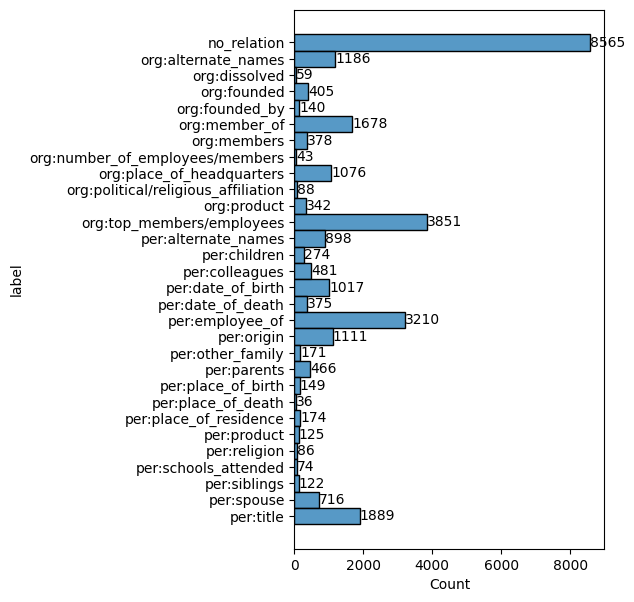

In [1830]:
plt.figure(figsize = (4, 7))
ax = sns.histplot(data=train_df.sort_values('label'), y='label')
ax.bar_label(ax.containers[1])
plt.show()

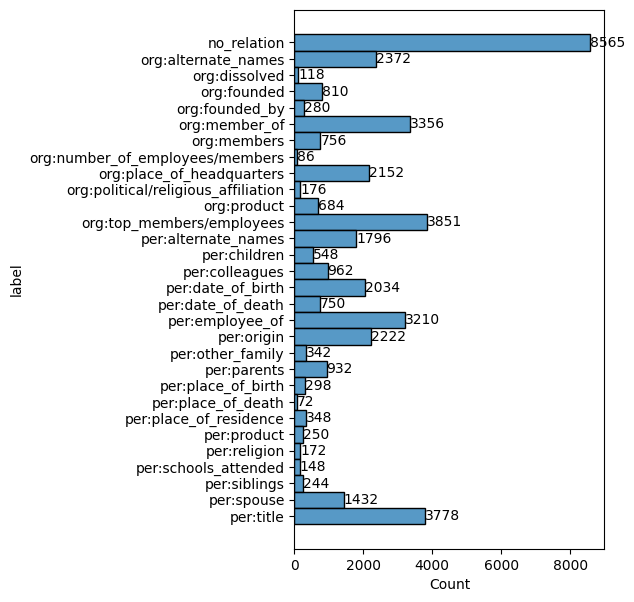

In [1831]:
plt.figure(figsize = (4, 7))
ax = sns.histplot(data=train_mr_df.sort_values('label'), y='label')
ax.bar_label(ax.containers[1])
plt.show()

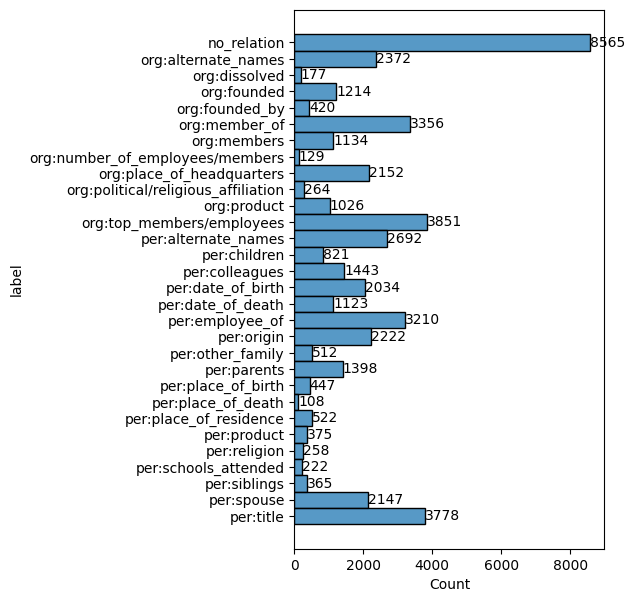

In [1862]:
plt.figure(figsize = (4, 7))
ax = sns.histplot(data=train_mr_mi_df.sort_values('label'), y='label')
ax.bar_label(ax.containers[1])
plt.show()

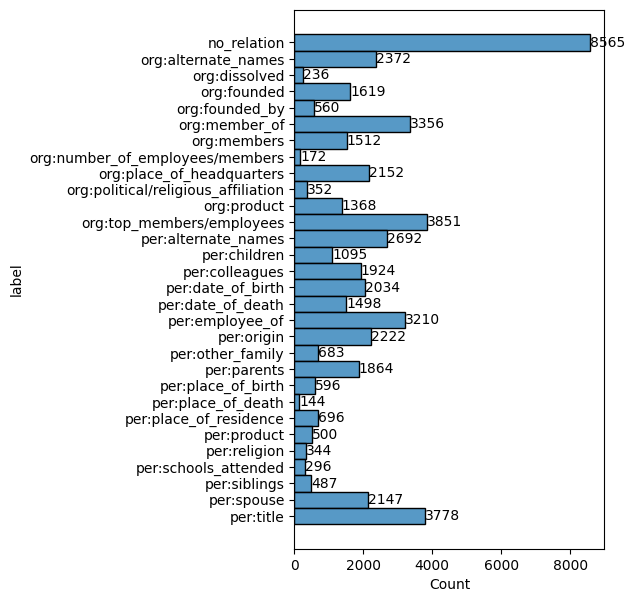

In [1861]:
plt.figure(figsize = (4, 7))
ax = sns.histplot(data=train_mr_mi_ht_df.sort_values('label'), y='label')
ax.bar_label(ax.containers[1])
plt.show()

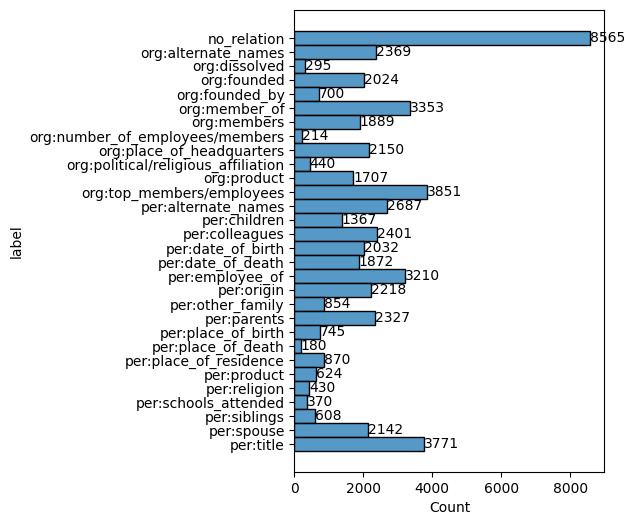

In [1930]:
plt.figure(figsize = (4, 6))
ax = sns.histplot(data=train_mr_mi_ht_aeda_df.sort_values('label'), y='label')
ax.bar_label(ax.containers[1])
plt.show()

# MR MI MR

In [1847]:
# label filtering
mr_mi_mr_df = label_filtering(train_mr_mi_df, 2000)
print(len(mr_mi_mr_df))

mr_mi_mr_df = mr_mi_mr_df.query('aug_method == "random_insertion"')
print(len(mr_mi_mr_df))

11958
3982


In [1848]:
mr_mi_mr_df = sentence_with_entity_marker(mr_mi_mr_df)

/opt/conda/envs/boost/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1849]:
mr_mi_mr_df['random_replacement_2'] = mr_mi_mr_df['sentence_with_entity_marker'].apply(lambda x: repeat_masking_replacement(x))

In [1850]:
mr_mi_mr_df = entity_re_indexing(mr_mi_mr_df, 'random_replacement_2')

In [1882]:
entity_check_after_cleaning(mr_mi_mr_df, 'random_replacement_2')

error:  1 '2019 코리아 스타트업 테크쇼'는 경상남도 , 창원시 , 경남지방중소벤처기업청이 공동 주최하고 창원 소재 와이즈유 영산대학교를 비롯한 8개 기관이 공동으로 주관하는 경남 지역 최대의 스타트업 축제이다. '2019 코리아 스타트업 테크쇼'는 경상남도 , ##진흥 , 경남지방중소벤처기업청이 공동 주최하고 창원 소재 와이즈유 영산대학교를 비롯한 8개 사가 공동으로 주관하는 경남 지역 최대의 스타트업 축제이다. 경상남도 창원시 경상남도 ##진흥
error:  2 하지만 최진실의 어머니 정옥숙 은 딸의 연예계 진출을 반대하였고 이에 최진실 ##세 은 배우에의 모든 꿈을 접어야 했다. 하지만 최진실의 아버지 ##순 은 딸의 연예계 진출을 반대하였고 이에 최진실 ##세 은 배우에의 모든 꿈을 접어야 했다. 최진실 정옥숙 최진실 ##순
error:  3 현대산업개발 은 해운대 아이파크 의 세계적인 건축가 다니엘 반 리베스킨트(Daniel Libeskind)와 함께 해운대의 입지를 활용해 설계했다. ##시티 은 해운대 아이파크 의 세계적인 건축가 다니엘 반 리베스킨트(Daniel Libeskind)와 함께 해운대의 입지를 살려 설계했다. 현대산업개발 아이파크 ##시티 아이파크
error:  4 청년당 (靑年黨)은 2012년 3월 19일 부터 2012년 4월 12일까지 존재했던 대한민국 대한민국의 진보주의 정당이다. 청년당 (靑年黨)은 ##년 3월 19일 부터 2012년 4월 12일까지 존재했던 대한민국 대한민국의 진보주의 정당이다. 청년당 2012년 3월 19일 청년당 ##년 3월 19일
error:  6 1947년 4월 지청천(池靑天)이 대동청년단(大同靑年團)을 조직하고 기존의 청년 단체들을 통합하자, 대동청년단 합류를 둘러싸고 서북청년회는 합동파와 합동반대파로 분열되었는데, 합동파는 1948년 9월 대동청년단에 통합되었다. 1947년 4월 지청천(池靑天)이 대동청년단(大同靑年團)을 조직하고 기존의 청년 단체들을 통합하자, ##들 합류를 둘러싸고 합동파

In [1896]:
# concat
#concat
train_mr_mi_mr_df = concat_dataset(train_mr_mi_df, mr_mi_mr_df, 'random_replacement_2')

# na chedk
# print('NA: ', train_mr_mi_mr_df.isna().sum())

# ducplicated check
# print('duplicated: ', train_mr_mi_mr_df[train_mr_mi_mr_df[['sentence', 'label', 'subject_entity', 'object_entity']].duplicated(keep=False)==True].sort_values('sentence'))

train_mr_mi_mr_df.drop_duplicates(['sentence', 'label', 'subject_entity', 'object_entity'], inplace=True)

aug_df_for_cocat:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')
total_df:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'aug_method'],
      dtype='object')
NA:  id                0
sentence          0
subject_entity    0
object_entity     0
label             0
source            0
aug_method        0
dtype: int64
duplicated:            id                                           sentence  \
48819  17520  1169년 1월 2일 누레딘 은 곧장 자신의 수도로 삼고 있는 다마스쿠스 에서 8천...   
43437  17520  1169년 1월 2일 누레딘 은 곧장 자신의 수도로 삼고 있는 다마스쿠스 에서 8천...   
47823  30284  11살때 그는 모스크바 총대주교 알렉세이 2세 가 참관한 가운데 피아노 독주회를 가...   
51958  30284  11살때 그는 모스크바 총대주교 알렉세이 2세 가 참관한 가운데 피아노 독주회를 가...   
47461  12629  12일 고양시 청은 인스타그램을 통해 고양시 마스코트 고양고양이 가 고양이 자이언트...   
...      ...                                                ...   
48840  29582  형제로는 이복언니 박재옥이 있고 동복동생인 막내 여동생 박근령 과 남동생 박지만 이...   
50702  20864       효명세자 는 1809년 9월 18일 순조와 순

In [1905]:
# ## 지우기
train_mr_mi_mr_df['sentence'] = train_mr_mi_mr_df['sentence'].apply(lambda x: x.replace('##', ''))
train_mr_mi_mr_df['sentence'] = train_mr_mi_mr_df['sentence'].apply(lambda x: re.sub('[ ]+', ' ', x))

# 이상값 행 제거
train_mr_mi_mr_df = train_mr_mi_mr_df[train_mr_mi_mr_df['subject_entity'].apply(lambda x: len(literal_eval(x)['word']) > 0)]
train_mr_mi_mr_df = train_mr_mi_mr_df[train_mr_mi_mr_df['object_entity'].apply(lambda x: len(literal_eval(x)['word']) > 0)]

In [1906]:
train_mr_mi_mr_df.drop_duplicates(['sentence', 'label', 'subject_entity', 'object_entity'], inplace=True)

In [1907]:
len(train_mr_mi_mr_df)

52008

In [1908]:
# save
train_mr_mi_mr_df.reset_index(drop=True).to_csv('train/train_mr_mi_mr_augmentation.csv', index=False)

## MR MI MR MI

In [1909]:
# label filtering
mr_mi_mr_mi_df = label_filtering(train_mr_mi_mr_df, 2000)
print(len(mr_mi_mr_mi_df))

mr_mi_mr_mi_df = mr_mi_mr_mi_df.query('aug_method == "random_replacement_2"')
print(len(mr_mi_mr_mi_df))

15660
3719


In [1910]:
mr_mi_mr_mi_df = sentence_with_entity_marker(mr_mi_mr_mi_df)

/opt/conda/envs/boost/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1913]:
mr_mi_mr_mi_df['random_insertion_2'] = mr_mi_mr_mi_df['sentence_with_entity_marker'].apply(lambda x: repeat_masking_insertion(x))

In [1920]:
mr_mi_mr_mi_df = mr_mi_mr_mi_df[mr_mi_mr_mi_df['random_insertion_2'].apply(lambda x: len(re.findall(r'\w*\[O1\].+\[O2\]', x))) > 0]

In [1921]:
mr_mi_mr_mi_df = entity_re_indexing(mr_mi_mr_mi_df, 'random_insertion_2')

/tmp/ipykernel_19091/3146106832.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[aug_method_name + '_sub_start_idx'] = None
/tmp/ipykernel_19091/3146106832.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[aug_method_name + '_sub_end_idx'] = None
/tmp/ipykernel_19091/3146106832.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [1922]:
entity_check_after_cleaning(mr_mi_mr_mi_df, 'random_insertion_2')

error:  1 '2019 코리아 스타트업 테크쇼'는 경상남도 , 진흥 , 경남지방중소벤처기업청이 공동 주최하고 창원 소재 와이즈유 영산대학교를 비롯한 8개 사가 공동으로 주관하는 경남 지역 최대의 스타트업 축제이다. 한편 '2019 코리아 모바일 스타트업 테크쇼'는 경상남도 , 진흥 , 경남지방중소벤처기업청이 공동 주최하고 창원 소재 와이즈유 영산대학교를 비롯한 8개 사가 공동으로 주관하는 경남 지역 최대의 스타트업 축제이다. 경상남도 ##진흥 경상남도 진흥 ,
error:  2 하지만 최진실의 아버지 순 은 딸의 연예계 진출을 반대하였고 이에 최진실 세 은 배우에의 모든 꿈을 접어야 했다. 하지만 당시 최진실의 아버지 순 은 딸의 연예계 진출을 반대하였고 이에 최진 실 세 은 결국 배우에의 모든 꿈을 접어야 했다. 최진실 ##순 실 세 순 은
error:  3 시티 은 해운대 아이파크 의 세계적인 건축가 다니엘 반 리베스킨트(Daniel Libeskind)와 함께 해운대의 입지를 살려 설계했다. 시티 은 해운대 아이 파크 의 ##으로 세계적인 건축가 다니엘 반 리베스킨트(Daniel von Libeskind)와 함께 해운대의 입지를 살려 설계했다. ##시티 아이파크 시티 은 파크 의
error:  4 청년당 (靑年黨)은 년 3월 19일 부터 2012년 4월 12일까지 존재했던 대한민국 대한민국의 진보주의 정당이다. 청년당 (靑年黨)은 년 3월 19일 부터 2012년 4월 12일까지 존재했던 대한민국 정당 대한민국의 진보주의 정당이다. 청년당 ##년 3월 19일 청년당 년 3월 19일 부터
error:  6 1947년 4월 지청천(池靑天)이 대동청년단(大同靑年團)을 조직하고 기존의 청년 단체들을 통합하자, 들 합류를 둘러싸고 합동파와 합동반대파로 분열되었는데, 합동파는 1948년 9월 대동청년단에 통합되었다. 1947년 4월 지청천(池靑天)이 대동청년단(大同靑年團)을 조직하고 기존의 청년 단체들을 통합하자, 들 합류 를 둘러싸고 합동파와 합동반대파로 분열되

In [1923]:
# concat
#concat
train_mr_mi_mr_mi_df = concat_dataset(train_mr_mi_mr_df, mr_mi_mr_mi_df, 'random_insertion_2')

# na chedk
# print('NA: ', train_mr_mi_mr_mi_df.isna().sum())

# ducplicated check
# print('duplicated: ', train_mr_mi_mr_mi_df[train_mr_mi_mr_mi_df[['sentence', 'label', 'subject_entity', 'object_entity']].duplicated(keep=False)==True].sort_values('sentence'))

train_mr_mi_mr_mi_df.drop_duplicates(['sentence', 'label', 'subject_entity', 'object_entity'], inplace=True)

aug_df_for_cocat:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')
total_df:  Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'aug_method'],
      dtype='object')
NA:  id                0
sentence          0
subject_entity    0
object_entity     0
label             0
source            0
aug_method        0
dtype: int64
duplicated:            id                                           sentence  \
50801  31000  1219년 (고종 6) 9월에 아버지 최충헌 이 추밀원부사(樞密院副使)로 뒤를 이어...   
54519  31000  1219년 (고종 6) 9월에 아버지 최충헌 이 추밀원부사(樞密院副使)로 뒤를 이어...   
51598  30398  1503년( 연산군 9) 휘신공주 는 생존시 구문경(具文璟)에게 출가하여 아들 구엄...   
55316  30398  1503년( 연산군 9) 휘신공주 는 생존시 구문경(具文璟)에게 출가하여 아들 구엄...   
49272  25996  1829년 제정 러시아의 니콜라이 이바노비치 로바쳅스키 (Nikolai Ivanov...   
...      ...                                                ...   
50569  22741        홍무제 의 손자이며, 영락제 의 인효문황후 서씨(仁孝文皇后 徐氏)의 장남이다.   
51251   7834                  홍익당 은 2017년 4월

In [1924]:
# ## 지우기
train_mr_mi_mr_mi_df['sentence'] = train_mr_mi_mr_mi_df['sentence'].apply(lambda x: x.replace('##', ''))
train_mr_mi_mr_mi_df['sentence'] = train_mr_mi_mr_mi_df['sentence'].apply(lambda x: re.sub('[ ]+', ' ', x))

# 이상값 행 제거
train_mr_mi_mr_mi_df = train_mr_mi_mr_mi_df[train_mr_mi_mr_mi_df['subject_entity'].apply(lambda x: len(literal_eval(x)['word']) > 0)]
train_mr_mi_mr_mi_df = train_mr_mi_mr_mi_df[train_mr_mi_mr_mi_df['object_entity'].apply(lambda x: len(literal_eval(x)['word']) > 0)]

In [1925]:
train_mr_mi_mr_mi_df.drop_duplicates(['sentence', 'label', 'subject_entity', 'object_entity'], inplace=True)
print(len(train_mr_mi_mr_mi_df))

55579


In [1926]:
# save
train_mr_mi_mr_mi_df.reset_index(drop=True).to_csv('train/train_mr_mi_mr_mi_augmentation.csv', index=False)